In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/corona-virus-report/usa_county_wise.csv
/kaggle/input/corona-virus-report/covid_19_clean_complete.csv


In [2]:
# thanks to:
#https://www.kaggle.com/shawon10/covid-19-easy-data-analysis-for-beginners
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
%matplotlib inline 
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"

In [3]:
#df=pd.read_csv('/kaggle/input/corona-virus-report/usa_county_wise.csv', na_filter=False)
df=pd.read_csv('/kaggle/input/corona-virus-report/usa_county_wise.csv', index_col='Date', parse_dates=True)
# df=df.drop(['UID'],axis=1)
#df=pd.read_csv('/kaggle/input/corona-virus-report/usa_county_wise.csv', parse_dates=True)


In [4]:
# define handy constants
date_string = "_20200427"
plot_file_ext = '.png'

In [5]:
def plotLineByDate(df, label, key):
    group = df.groupby('Date')[key].sum().reset_index()

    fig = px.line(group, x="Date", y=key, 
                  title=label + " " + key + " Over Time")

    fig.show()

In [6]:
def plotKey2LineByDate(df, label, key1, key2):

    plt.figure(figsize=(12, 8))

    group_c = df.groupby('Date')[key1].sum().reset_index()
    group_d = df.groupby('Date')[key2].sum().reset_index()
    
    # gca stands for 'get current axis'
    ax = plt.gca()
    group_c.plot(kind='line',x='Date',y=key1,ax=ax)
    group_d.plot(kind='line',x='Date',y=key2,ax=ax)

    plt.title(label + " Cases over Time")
    #plt.grid(True, color='r', linestyle='-', linewidth=2)
    plt.grid(True)
    plt.savefig(label + date_string + plot_file_ext)
    plt.show()

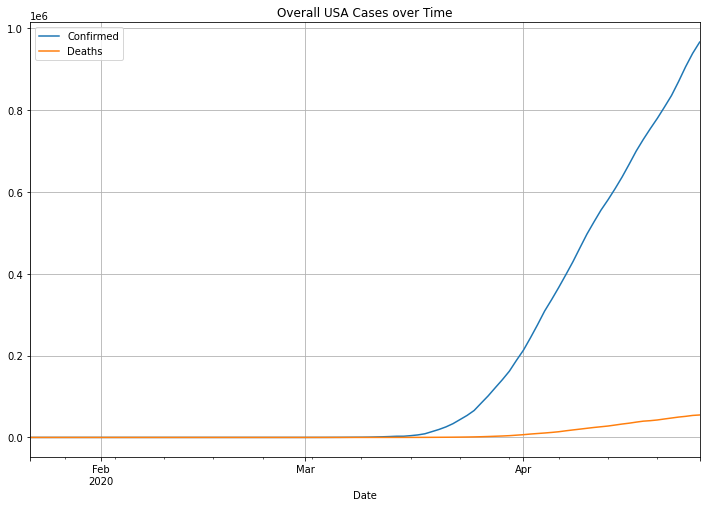

In [7]:
df_usa = df
plotKey2LineByDate(df_usa, 'Overall USA', 'Confirmed', 'Deaths')
plotLineByDate(df_usa, "Overall USA", "Confirmed")
plotLineByDate(df_usa, "Overall USA", "Deaths")


In [8]:
df_usa.tail(10)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Confirmed,Deaths
Date,,,,,,,,,,,,,
2020-04-26,84099999.0,US,USA,840,99999.0,NaN,Grand Princess,US,0.000000,0.000000,"Grand Princess, US",103,3
2020-04-26,84070004.0,US,USA,840,NaN,Michigan Department of Corrections (MDOC),Michigan,US,0.000000,0.000000,"Michigan Department of Corrections (MDOC), Mic...",1031,32
2020-04-26,84070005.0,US,USA,840,NaN,Federal Correctional Institution (FCI),Michigan,US,0.000000,0.000000,"Federal Correctional Institution (FCI), Michig...",81,1
2020-04-26,84070015.0,US,USA,840,NaN,Bear River,Utah,US,41.521068,-113.083282,"Bear River, Utah, US",60,1
2020-04-26,84070016.0,US,USA,840,NaN,Central Utah,Utah,US,39.372319,-111.575868,"Central Utah, Utah, US",21,0
2020-04-26,84070017.0,US,USA,840,NaN,Southeast Utah,Utah,US,38.996171,-110.701396,"Southeast Utah, Utah, US",12,0
2020-04-26,84070018.0,US,USA,840,NaN,Southwest Utah,Utah,US,37.854472,-111.441876,"Southwest Utah, Utah, US",87,2
2020-04-26,84070019.0,US,USA,840,NaN,TriCounty,Utah,US,40.124915,-109.517442,"TriCounty, Utah, US",10,0
2020-04-26,84070020.0,US,USA,840,NaN,Weber-Morgan,Utah,US,41.271160,-111.914512,"Weber-Morgan, Utah, US",145,2


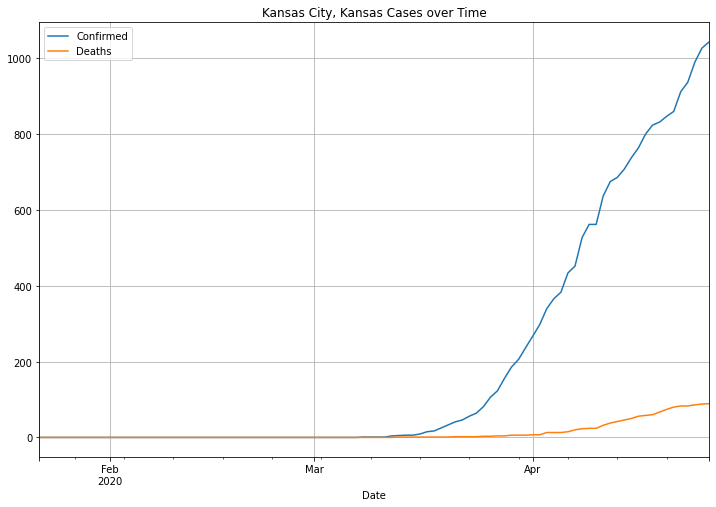

In [9]:
kansas_city_ks=df.loc[(df['Combined_Key'] == 'Wyandotte, Kansas, US') | 
                   (df['Combined_Key'] == 'Douglas, Kansas, US') | 
                   (df['Combined_Key'] == 'Johnson, Kansas, US')]
kansas_city_ks.tail(5)

plotKey2LineByDate(kansas_city_ks, 'Kansas City, Kansas', 'Confirmed', 'Deaths')

plotLineByDate(kansas_city_ks, "Kansas City, Kansas", "Confirmed")
plotLineByDate(kansas_city_ks, "Kansas City, Kansas", "Deaths")

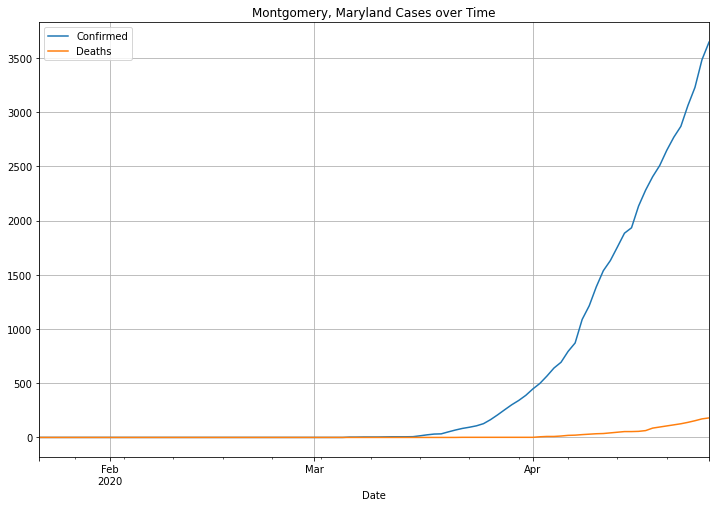

In [10]:
# Montgomery, maryland
montgomery_md=df.loc[df['Combined_Key'] == 'Montgomery, Maryland, US']
montgomery_md.head(30)
plotKey2LineByDate(montgomery_md, 'Montgomery, Maryland', 'Confirmed', 'Deaths')
plotLineByDate(montgomery_md, "Montgomery, Maryland", "Confirmed")
plotLineByDate(montgomery_md, "Montgomery, Maryland", "Deaths")

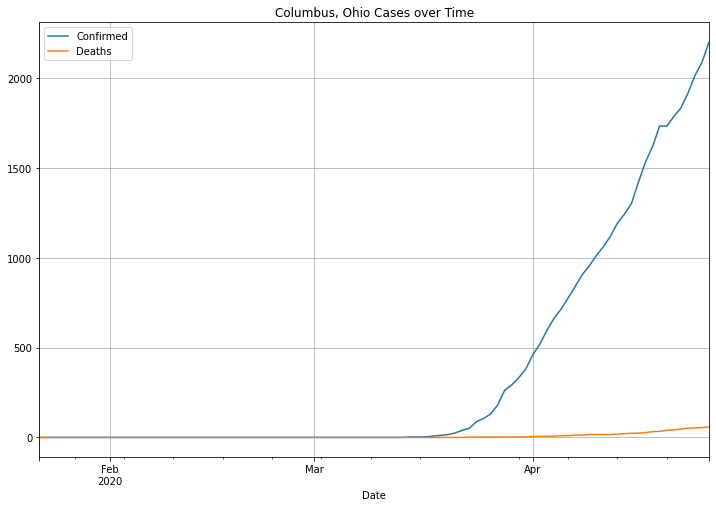

In [11]:
#columbus, ohio - Franklin Delaware Fairfield 
columbus_oh=df.loc[(df['Combined_Key'] == 'Franklin, Ohio, US') | 
                   (df['Combined_Key'] == 'Delaware, Ohio, US') | 
                   (df['Combined_Key'] == 'Fairfield, Ohio, US')]
columbus_oh.tail(5)
plotKey2LineByDate(columbus_oh, 'Columbus, Ohio', 'Confirmed', 'Deaths')
plotLineByDate(columbus_oh, "Columbus, Ohio", "Confirmed")
plotLineByDate(columbus_oh, "Columbus, Ohio", "Deaths")

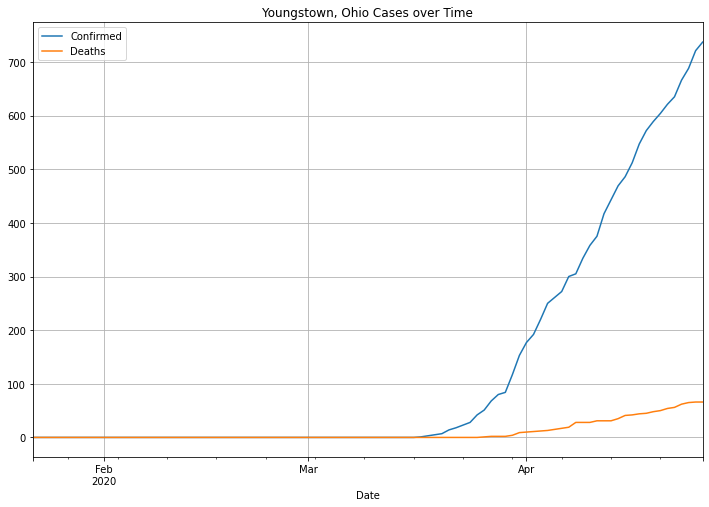

In [12]:
#youngstown, ohio - Mahoning
youngstown_oh=df.loc[df['Admin2'] == 'Mahoning']
youngstown_oh.tail(5)
plotKey2LineByDate(youngstown_oh, 'Youngstown, Ohio', 'Confirmed', 'Deaths')
plotLineByDate(youngstown_oh, "Youngstown, Ohio", "Confirmed")
plotLineByDate(youngstown_oh, "Youngstown, Ohio", "Deaths")

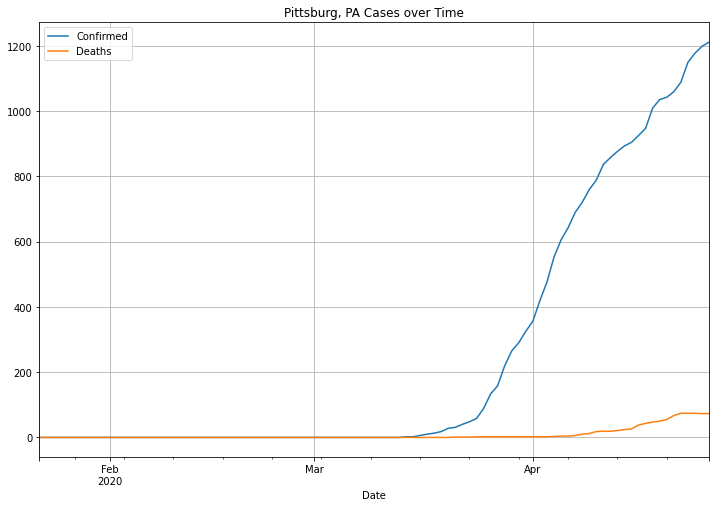

In [13]:
# Pittsburg - Allegheny
pittsburg_pa=df.loc[df['Admin2'] == 'Allegheny']
pittsburg_pa.tail(5)
plotKey2LineByDate(pittsburg_pa, 'Pittsburg, PA', 'Confirmed', 'Deaths')
plotLineByDate(pittsburg_pa, "Pittsburg, PA", "Confirmed")
plotLineByDate(pittsburg_pa, "Pittsburg, PA", "Deaths")

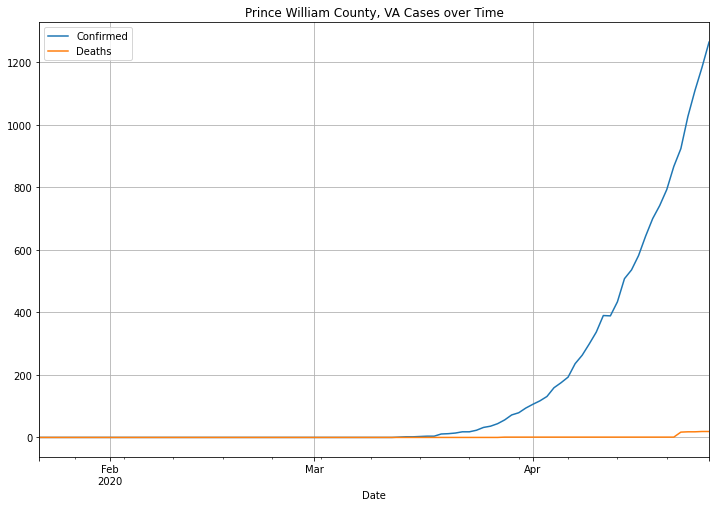

In [14]:
# Haymarket - Prince William
haymarket_va=df.loc[df['Admin2'] == 'Prince William']
haymarket_va.tail(5)
plotKey2LineByDate(haymarket_va, 'Prince William County, VA', 'Confirmed', 'Deaths')
plotLineByDate(haymarket_va, "Prince William County, VA", "Confirmed")
plotLineByDate(haymarket_va, "Prince William County, VA", "Deaths")

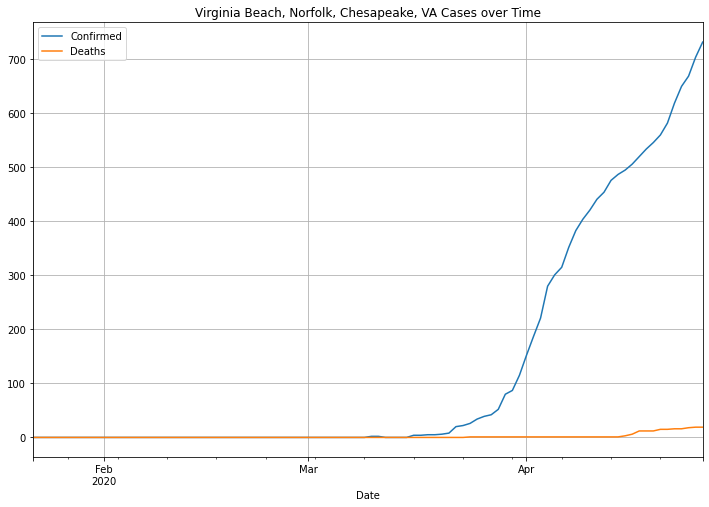

In [15]:
#Virginia Beach, Virginia
virginia_beach_va=df.loc[(df['Combined_Key'] == 'Virginia Beach, Virginia, US') | 
                         (df['Combined_Key'] == 'Chesapeake, Virginia, US') | 
                         (df['Combined_Key'] == 'Norfolk, Virginia, US')]
virginia_beach_va.tail(5)
plotKey2LineByDate(virginia_beach_va, 'Virginia Beach, Norfolk, Chesapeake, VA', 'Confirmed', 'Deaths')
plotLineByDate(virginia_beach_va, "Virginia Beach, Norfolk, Chesapeake, VA", "Confirmed")
plotLineByDate(virginia_beach_va, "Virginia Beach, Norfolk, Chesapeake, VA", "Deaths")

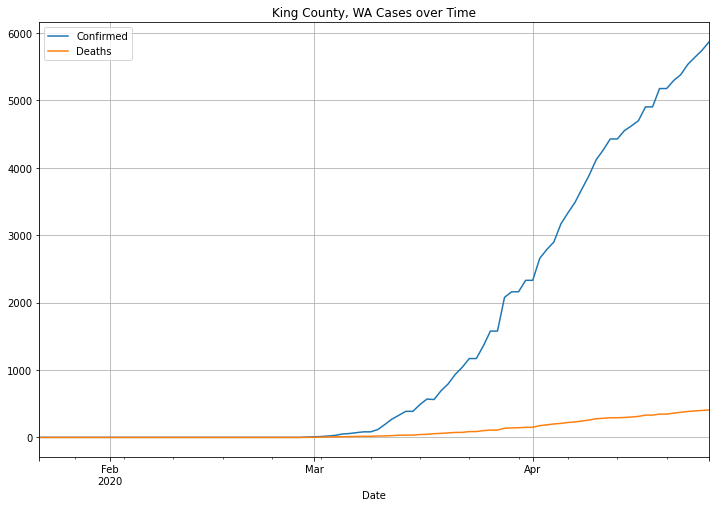

In [16]:
#king, WA
king_wa=df.loc[(df['Combined_Key'] == 'King, Washington, US')]
king_wa.tail(5) # 4/1/20
# seatle_wa=df.loc[(df['Combined_Key'] == 'King, Washington, US') | 
#                     (df['Combined_Key'] == 'Snohomish, Washington, US')]
# #seatle_wa.head(5) # 1/22/20
# seatle_wa.tail(5) # 4/1/20
plotKey2LineByDate(king_wa, 'King County, WA', 'Confirmed', 'Deaths')
plotLineByDate(king_wa, "King County, WA", "Confirmed")
plotLineByDate(king_wa, "King County, WA", "Deaths")

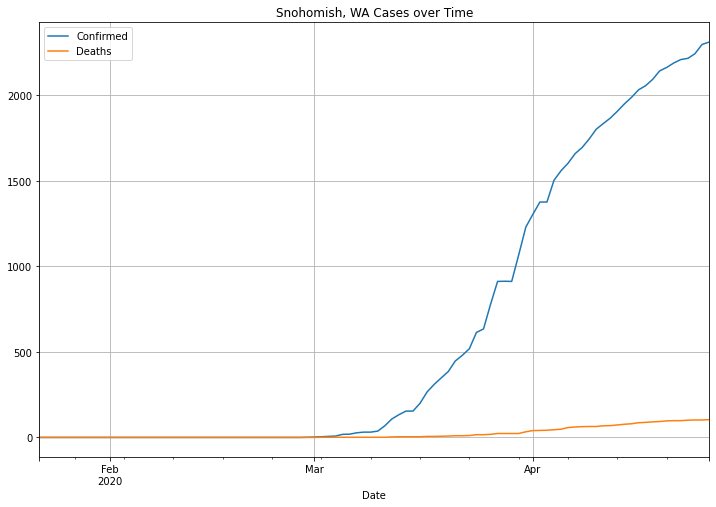

In [17]:
#Snohomish, WA
snohomish_wa=df.loc[(df['Combined_Key'] == 'Snohomish, Washington, US')]
snohomish_wa.tail(5)
plotKey2LineByDate(snohomish_wa, 'Snohomish, WA', 'Confirmed', 'Deaths')
plotLineByDate(snohomish_wa, "Snohomish, WA", "Confirmed")
plotLineByDate(snohomish_wa, "Snohomish, WA", "Deaths")

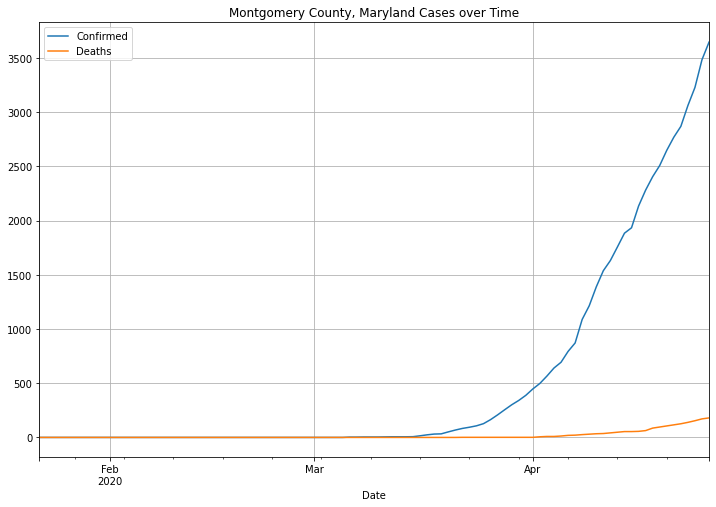

In [18]:
plotKey2LineByDate(montgomery_md, 'Montgomery County, Maryland', 'Confirmed', 'Deaths')

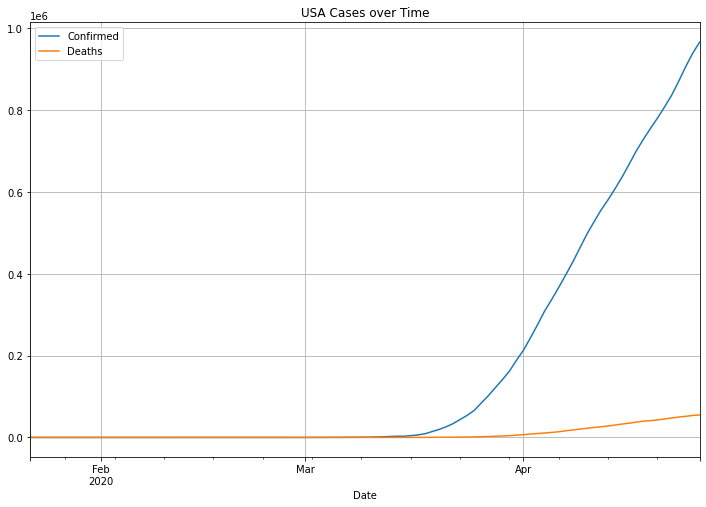

In [19]:
plotKey2LineByDate(df_usa, 'USA', 'Confirmed', 'Deaths')

In [20]:
# # extract states of interest from USA overall
# df = df_usa
# df=df_usa.loc[(df['Province_State'] == 'Kansas') | 
#               (df['Province_State'] == 'Maryland') | 
#               (df['Province_State'] == 'Ohio') |
#               (df['Province_State'] == 'Pennsylvania') | 
#               (df['Province_State'] == 'Virginia') | 
#               (df['Province_State'] == 'Washington') | 
#               (df['Province_State'] == 'New York') ]
# #df.tail(20)
#               # df=df_usa.loc[(df['Combined_Key'] == 'Wyandotte, Kansas, US') | 
# #               (df['Combined_Key'] == 'Douglas, Kansas, US') | 
# #               (df['Combined_Key'] == 'Johnson, Kansas, US') |
# #               (df['Combined_Key'] == 'Montgomery, Maryland, US') | 
# #               (df['Combined_Key'] == 'Franklin, Ohio, US') | 
# #               (df['Combined_Key'] == 'Delaware, Ohio, US') | 
# #               (df['Combined_Key'] == 'Fairfield, Ohio, US') ]

# #               (df['Admin2'] == 'Mahoning') |
# #               (df['Admin2'] == 'Allegheny') |
# #               (df['Admin2'] == 'Prince William') |
# #               (df['Combined_Key'] == 'Virginia Beach, Virginia, US') | 
# #               (df['Combined_Key'] == 'Chesapeake, Virginia, US') | 
# #               (df['Combined_Key'] == 'Norfolk, Virginia, US') |
# #               (df['Combined_Key'] == 'King, Washington, US') |
# #               (df['Combined_Key'] == 'Snohomish, Washington, US') ]

# # create dummy variable them group by that
# # set the legend to false because we'll fix it later
# df.assign(dummy = 1).groupby(
#     ['dummy','Province_State']
# ).size().to_frame().unstack().plot(kind='bar',stacked=True,legend=False)
# #   ['dummy','Province_State']
# #   ['dummy',('Province_State'=="WA") | ('Province_State'=="NY")]
# #   ['dummy',(('Province_State'=='WA') | ('Province_State'=='NY'))]

# plt.title('Number of Confirmed by State')

# # other it'll show up as 'dummy' 
# plt.xlabel('state')

# # disable ticks in the x axis
# plt.xticks([])

# # fix the legend
# current_handles, _ = plt.gca().get_legend_handles_labels()
# reversed_handles = reversed(current_handles)

# labels = reversed(df['Province_State'].unique())

# # labels & legends are WRONG!
# #plt.legend(current_handles,labels,loc='lower right')
# plt.legend(reversed_handles,labels,loc='lower right')
# plt.show()

In [21]:
# group_k = kansas_city_ks.groupby('Date')['Confirmed'].sum().reset_index()
# group_m = montgomery_md.groupby('Date')['Confirmed'].sum().reset_index()
# group_o1 = columbus_oh.groupby('Date')['Confirmed'].sum().reset_index()
# group_o2 = youngstown_oh.groupby('Date')['Confirmed'].sum().reset_index()
# group_p = pittsburg_pa.groupby('Date')['Confirmed'].sum().reset_index()
# group_v1 = haymarket_va.groupby('Date')['Confirmed'].sum().reset_index()
# group_v2 = virginia_beach_va.groupby('Date')['Confirmed'].sum().reset_index()
# group_w1 = king_wa.groupby('Date')['Confirmed'].sum().reset_index()
# group_w2 = snohomish_wa.groupby('Date')['Confirmed'].sum().reset_index()

# plt.figure(figsize=(12, 8))
# plt.title("US_Selected_Counties Confirmed Cases over Time")
# # gca stands for 'get current axis'
# ax = plt.gca()

# group_w1.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="king_wa", color='red')
# group_w2.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="snohomish_wa")
# group_m.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="montgomery_md")
# group_o1.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="columbus_oh")
# group_p.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="pittsburg_pa")
# group_k.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="kansas_city_ks")
# group_v2.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="virginia_beach_va")
# group_o2.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="youngstown_oh")
# group_v1.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="prince_william_va")
# #df.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)

# #plt.savefig("US_Selected_Counties" + '_20200407.png')
# plt.savefig("US_Selected_Counties" + date_string + plot_file_ext)

# plt.show()

In [22]:
def plotAll(key, label):
    group_k = kansas_city_ks.groupby('Date')[key].sum().reset_index()
    group_m = montgomery_md.groupby('Date')[key].sum().reset_index()
    group_o1 = columbus_oh.groupby('Date')[key].sum().reset_index()
    group_o2 = youngstown_oh.groupby('Date')[key].sum().reset_index()
    group_p = pittsburg_pa.groupby('Date')[key].sum().reset_index()
    group_v1 = haymarket_va.groupby('Date')[key].sum().reset_index()
    group_v2 = virginia_beach_va.groupby('Date')[key].sum().reset_index()
    group_w1 = king_wa.groupby('Date')[key].sum().reset_index()
    group_w2 = snohomish_wa.groupby('Date')[key].sum().reset_index()

    plt.figure(figsize=(12, 8))
    plt.title("US_Selected_Counties " + key + label)
    # gca stands for 'get current axis'
    ax = plt.gca()

    group_w1.plot(kind='line',x='Date',y=key,ax=ax, label="king_wa", color='red')
    group_w2.plot(kind='line',x='Date',y=key,ax=ax, label="snohomish_wa")
    group_m.plot(kind='line',x='Date',y=key,ax=ax, label="montgomery_md")
    group_o1.plot(kind='line',x='Date',y=key,ax=ax, label="columbus_oh")
    group_p.plot(kind='line',x='Date',y=key,ax=ax, label="pittsburg_pa")
    group_k.plot(kind='line',x='Date',y=key,ax=ax, label="kansas_city_ks")
    group_v2.plot(kind='line',x='Date',y=key,ax=ax, label="virginia_beach_va")
    group_o2.plot(kind='line',x='Date',y=key,ax=ax, label="youngstown_oh")
    group_v1.plot(kind='line',x='Date',y=key,ax=ax, label="prince_william_va")
    #df.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)

    plt.grid(True)
    plt.savefig("US_Selected_Counties" + key + date_string + plot_file_ext)

    plt.show()

In [23]:
def plotAllLessKing(key, label):
    group_k = kansas_city_ks.groupby('Date')[key].sum().reset_index()
    group_m = montgomery_md.groupby('Date')[key].sum().reset_index()
    group_o1 = columbus_oh.groupby('Date')[key].sum().reset_index()
    group_o2 = youngstown_oh.groupby('Date')[key].sum().reset_index()
    group_p = pittsburg_pa.groupby('Date')[key].sum().reset_index()
    group_v1 = haymarket_va.groupby('Date')[key].sum().reset_index()
    group_v2 = virginia_beach_va.groupby('Date')[key].sum().reset_index()
    #group_w1 = king_wa.groupby('Date')[key].sum().reset_index()
    group_w2 = snohomish_wa.groupby('Date')[key].sum().reset_index()

    plt.figure(figsize=(12, 8))
    plt.title("US_Selected_Counties Less King " + key + label)
    # gca stands for 'get current axis'
    ax = plt.gca()

    #group_w1.plot(kind='line',x='Date',y=key,ax=ax, label="king_wa", color='red')
    group_w2.plot(kind='line',x='Date',y=key,ax=ax, label="snohomish_wa", color='red')
    group_m.plot(kind='line',x='Date',y=key,ax=ax, label="montgomery_md")
    group_o1.plot(kind='line',x='Date',y=key,ax=ax, label="columbus_oh")
    group_p.plot(kind='line',x='Date',y=key,ax=ax, label="pittsburg_pa")
    group_k.plot(kind='line',x='Date',y=key,ax=ax, label="kansas_city_ks")
    group_v2.plot(kind='line',x='Date',y=key,ax=ax, label="virginia_beach_va")
    group_o2.plot(kind='line',x='Date',y=key,ax=ax, label="youngstown_oh")
    group_v1.plot(kind='line',x='Date',y=key,ax=ax, label="prince_william_va")
    #df.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)

    plt.grid(True)
    plt.savefig("US_Selected_Counties_LessKing" + key + date_string + plot_file_ext)

    plt.show()

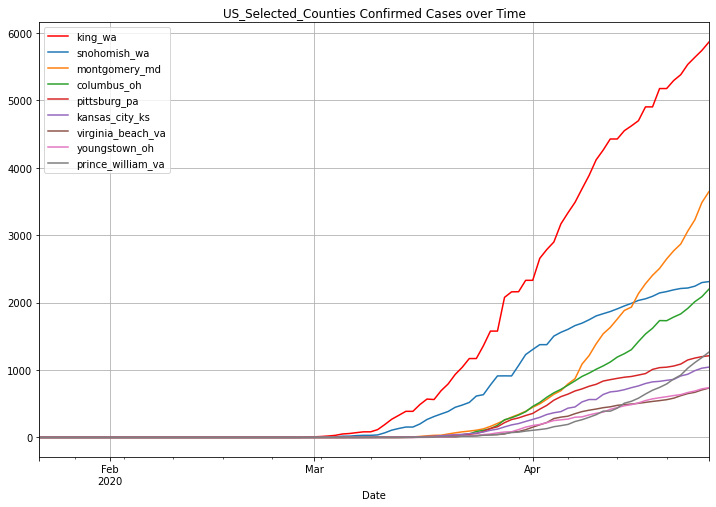

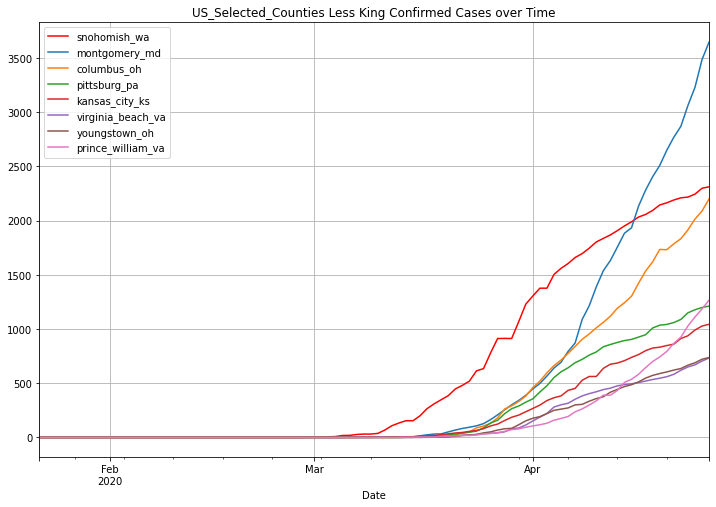

In [24]:
plotAll("Confirmed", " Cases over Time")
plotAllLessKing("Confirmed", " Cases over Time")

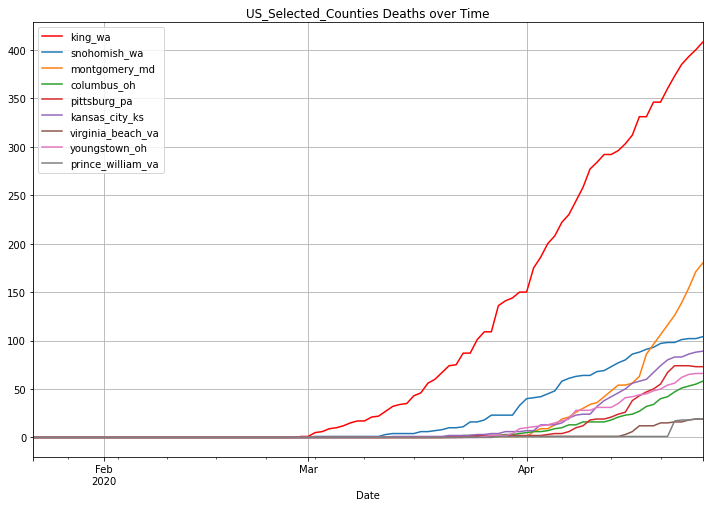

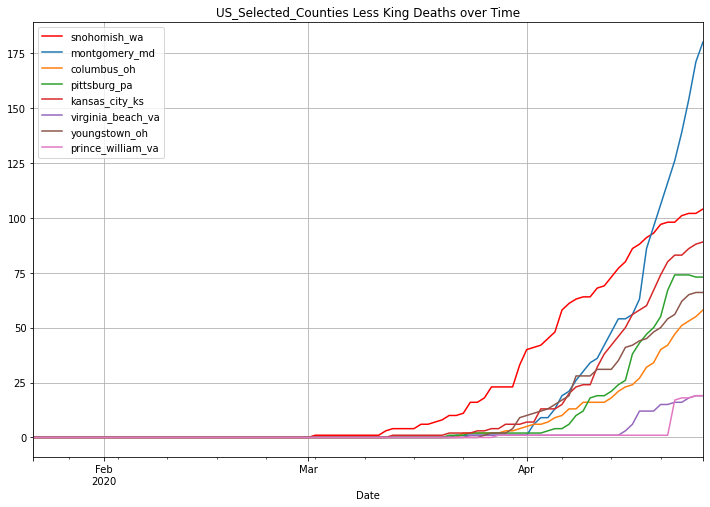

In [25]:
plotAll("Deaths", " over Time")
plotAllLessKing("Deaths", " over Time")

In [26]:
# # gca stands for 'get current axis'
# ax = plt.gca()

# # log scale
# group_w1.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="king_wa", logy=True)
# group_w2.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="snohomish_wa", logy=True)
# group_m.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="montgomery_md", logy=True)
# group_o1.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="columbus_oh", logy=True)
# group_p.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="pittsburg_pa", logy=True)
# group_k.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="kansas_city_ks", logy=True)
# group_v2.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="virginia_beach_va", logy=True)
# group_o2.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="youngstown_oh", logy=True)
# group_v1.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="prince_william_va", logy=True)

# # group_k.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="kansas_city_ks", logy=True)
# # group_m.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="montgomery_md", logy=True)
# # group_o1.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="columbus_oh", logy=True)
# # group_o2.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="youngstown_oh", logy=True)
# # group_p.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="pittsburg_pa", logy=True)
# # group_v1.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="haymarket_va", logy=True)
# # group_v2.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="virginia_beach_va", logy=True)
# # group_w1.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="king_wa", logy=True)
# # group_w2.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="snohomish_wa", logy=True)

# #df.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)

# #plt.savefig('logy_20200407.png')
# plt.savefig('logy' + date_string + plot_file_ext)

# plt.show()

In [27]:
# # gca stands for 'get current axis'
# ax = plt.gca()

# # log scale
# group_k.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="kansas_city_ks", logx=True, logy=True)
# group_m.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="montgomery_md", logx=True, logy=True)
# group_o1.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="columbus_oh", logx=True, logy=True)
# group_o2.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="youngstown_oh", logx=True, logy=True)
# group_p.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="pittsburg_pa", logx=True, logy=True)
# group_v1.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="haymarket_va", logx=True, logy=True)
# group_v2.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="virginia_beach_va", logx=True, logy=True)
# group_w1.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="king_wa", logx=True, logy=True)
# group_w2.plot(kind='line',x='Date',y='Confirmed',ax=ax, label="snohomish_wa", logx=True, logy=True)

# #df.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)

# plt.savefig('logy_20200407.png')
# plt.show()

In [28]:
def plotAllLogy(key, label):
    group_k = kansas_city_ks.groupby('Date')[key].sum().reset_index()
    group_m = montgomery_md.groupby('Date')[key].sum().reset_index()
    group_o1 = columbus_oh.groupby('Date')[key].sum().reset_index()
    group_o2 = youngstown_oh.groupby('Date')[key].sum().reset_index()
    group_p = pittsburg_pa.groupby('Date')[key].sum().reset_index()
    group_v1 = haymarket_va.groupby('Date')[key].sum().reset_index()
    group_v2 = virginia_beach_va.groupby('Date')[key].sum().reset_index()
    group_w1 = king_wa.groupby('Date')[key].sum().reset_index()
    group_w2 = snohomish_wa.groupby('Date')[key].sum().reset_index()

    plt.figure(figsize=(12, 8))
    plt.title("US_Selected_Counties " + key + label)

    # gca stands for 'get current axis'
    ax = plt.gca()

    # log scale
    group_w1.plot(kind='line',x='Date',y=key,ax=ax, label="king_wa", logy=True)
    group_w2.plot(kind='line',x='Date',y=key,ax=ax, label="snohomish_wa", logy=True)
    group_m.plot(kind='line',x='Date',y=key,ax=ax, label="montgomery_md", logy=True)
    group_o1.plot(kind='line',x='Date',y=key,ax=ax, label="columbus_oh", logy=True)
    group_p.plot(kind='line',x='Date',y=key,ax=ax, label="pittsburg_pa", logy=True)
    group_k.plot(kind='line',x='Date',y=key,ax=ax, label="kansas_city_ks", logy=True)
    group_v2.plot(kind='line',x='Date',y=key,ax=ax, label="virginia_beach_va", logy=True)
    group_o2.plot(kind='line',x='Date',y=key,ax=ax, label="youngstown_oh", logy=True)
    group_v1.plot(kind='line',x='Date',y=key,ax=ax, label="prince_william_va", logy=True)

    #df.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)

    plt.grid(True)
    plt.savefig('US_Selected_Counties-logy' + date_string + plot_file_ext)

    plt.show()

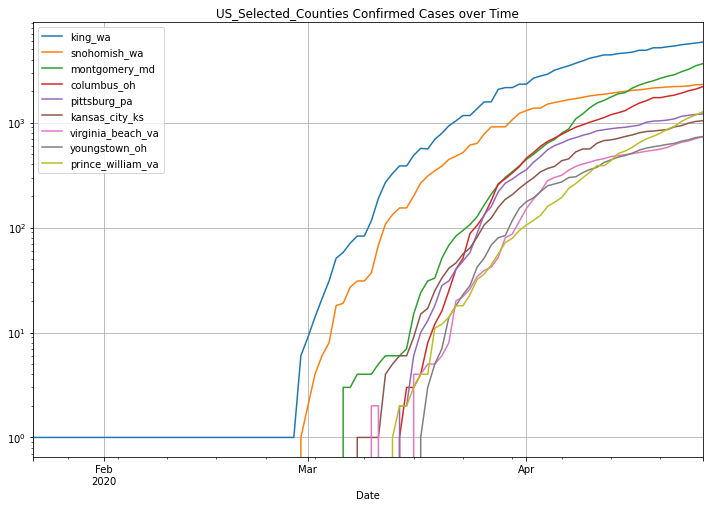

In [29]:
plotAllLogy("Confirmed", " Cases over Time")

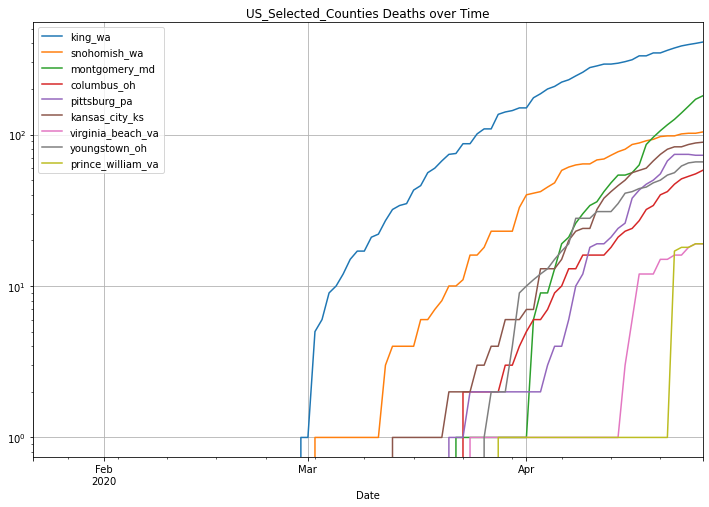

In [30]:
plotAllLogy("Deaths", " over Time")